## Imports and paths

In [562]:
import numpy as np
import warnings
from matplotlib import pyplot as plt

DATA_PATH = "data/cudo6.png"

## Interpolation function

In [563]:
def map(image, mapping, interpolation):
    if interpolation == "nn":
        mapping = np.rint(mapping).astype(int)
        x = mapping[0]
        y = mapping[1]
        # Find out which coordinates should be None
        x_nones_parts = np.where(((x < 0) | (x >= image.shape[0] - 1)))
        x_nones = list(zip(x_nones_parts[0], x_nones_parts[1]))
        y_nones_parts = np.where(((y < 0) | (y >= image.shape[1] - 1)))
        y_nones = list(zip(y_nones_parts[0], y_nones_parts[1]))
        nones = np.concatenate((x_nones, y_nones))
        # Clip values from 0 to max shape
        np.clip(x, 0, image.shape[0]-1, x)
        np.clip(y, 0, image.shape[1]-1, y)
        ret_img = image[x, y]
        for coord in nones:
            ret_img[coord[0], coord[1]] = None
        return ret_img

    elif interpolation == "bi":
        x1, y1 = np.int32(np.floor(mapping))
        x2, y2 = np.int32(np.ceil(mapping))
        # Clip out of bounds
        np.clip(x1, 0, image.shape[0] - 1, x1)
        np.clip(x2, 0, image.shape[0] - 1, x2)
        np.clip(y1, 0, image.shape[1] - 1, y1)
        np.clip(y2, 0, image.shape[1] - 1, y2)
        R1 = np.empty(shape=(mapping.shape[1], mapping.shape[2], 4))
        R2 = np.empty(shape=(mapping.shape[1], mapping.shape[2], 4))
        P = np.empty(shape=(mapping.shape[1], mapping.shape[2], 4))

        for i in range(4):
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                R1[:,:,i] = (((x2 - mapping[0])/(x2 - x1)) * image[x1, y1, i]) + (((mapping[0] - x1)/(x2 - x1)) * image[x2, y1, i])
                R2[:,:,i] = (((x2 - mapping[0])/(x2 - x1)) * image[x1, y2, i]) + (((mapping[0] - x1)/(x2 - x1)) * image[x2, y2, i])
                P[:,:,i] = ((y2 - mapping[1])/(y2 - y1) * R1[:,:,i]) + ((mapping[1] - y1)/(y2 - y1) * R2[:,:,i])
        return P


## Utilities

In [564]:
def rotate(pts, rds):
    theta = np.radians(rds)
    # Rotation operation:
    # Rv = [xcos(theta) - ysin(theta), xsin(theta) + ycos(theta)]
    r_pts_x = pts[0] * np.cos(theta) + pts[1] * np.sin(theta)
    r_pts_y = pts[1] * np.cos(theta) - pts[0] * np.sin(theta)
    return np.array([r_pts_y, r_pts_x])


def plot_points(pts):
    plt.figure()
    plt.imshow(img)
    plt.plot(pts[1, :], pts[0, :])

def preprocess(img, shape=(128,128), translation=(128, 128), rotation=45):
    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    # new_x and new_y represent the indices we need to interpolate
    new_x = ((img.shape[0]-1) / (shape[0]-1)) * x
    new_y = ((img.shape[1]-1) / (shape[1]-1)) * y

    # Rotate newly created points
    return_points = np.array([new_y, new_x])
    return_points = rotate(return_points, rotation)

    # Move and scale mapping
    return_points[0] += translation[0]
    return_points[1] += translation[1]

    return return_points

## Reading data

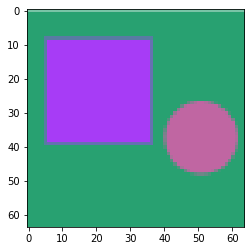

In [565]:
img = plt.imread(DATA_PATH)
plt.imshow(img)

## Nearest neighbor interpolation

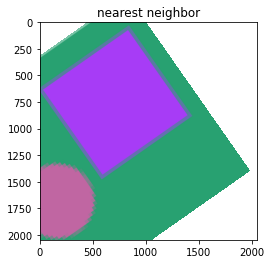

In [566]:
shp = (2048, 2048)
mapping = preprocess(img, shape=shp, translation=(-8, 25), rotation=-55)
nn_interpolated = map(img, mapping, "nn")
plt.figure()
plt.title("nearest neighbor")
plt.imshow(nn_interpolated)
plt.imsave("out_nn.png", nn_interpolated)

## Bilinear interpolation

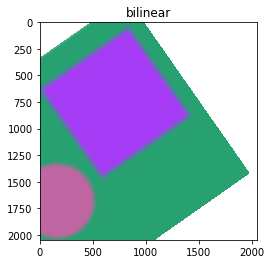

In [567]:
shp = (2048, 2048)
mapping = preprocess(img, shape=shp, translation=(-8, 25), rotation=-55)
bi_interpolated = map(img, mapping, "bi")
plt.figure()
plt.title("bilinear")
plt.imshow(bi_interpolated)
plt.imsave("out_bi.png", bi_interpolated)